In [1]:
# from Model import LinearModelV2 
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd 

In [2]:
from Utils import ConfigSampler

In [3]:
sampler = ConfigSampler()

In [4]:
sampler.sample_config()

{'batch_size': 16,
 'embed_size': 100,
 'n_encoder_layers': 5,
 'n_ffout_layers': 4,
 'activation_function': 'LeakyReLU',
 'dropout': 0.2,
 'batch_normalization': True,
 'aggregation': True,
 'learning_rate': 0.0001}

In [1]:
import pickle 
with open("../media2/binary/optimization/tried_configs.txt", "rb") as f:
    a = pickle.load(f)

print(type(a))

<class 'set'>


In [30]:
sampler.draws

1

In [31]:
class OptimizationModel(nn.Module):
    def _generate_layer_size(max_val, min_val, num_values):
        """Generate `num_values` integers between `min_val` and `max_val`."""
        if min_val >= max_val:
            raise ValueError("min_val must be less than max_val.")
        if num_values < 1:
            raise ValueError("num_values must be at least 1.")

        # Generate evenly spaced values between min_val and max_val
        values = np.linspace(min_val, max_val, num_values, dtype=int)

        # Ensure the result is sorted in descending order (if desired)
        return sorted(values, reverse=True)
    
    def combine_vec(self, list_vec):
        combined = None

        if self.conc: 
            combined = torch.cat(list_vec, dim=1)
        else:
            combined = torch.sum(torch.stack(list_vec), dim=0)
        return combined
        # if torch.is_tensor(vec3):
        #     if not self.concat:
        #         combined = torch.add(torch.add(vec1, vec2), vec3)
        #     elif self.concat:
        #         combined = torch.cat((vec1, vec2, vec3), dim=1)
        #     else:
        #         raise ValueError("incorrect concatenation argument")

        # else:
        #     if self.combined_size == 200:
        #         combined = torch.add(vec1, vec2)
        #     elif self.combined_size == 400:
        #         combined = torch.cat((vec1, vec2), dim=1)
        #     else:
        #         raise ValueError("incorrect concatenation argument")
        # return combined


    def __init__(self, embed_size,  n_classes, enc_layers=3, ffout_layers=3, act="ReLU", dropout=0.2, batch_norm=True, concat=True):
        super().__init__()
        self.conc = concat
        self.n_class = 1 if n_classes <= 2 else n_classes
        self.flatten = nn.Flatten()
        self.encoder_batchnorm = nn.BatchNorm1d(2) if batch_norm else nn.Identity()
        self.ffout_batchnorm = nn.LazyBatchNorm1d() if batch_norm else nn.Identity()
        self.out_act = nn.Identity() if self.n_class > 2 else nn.Sigmoid()
        self.combined_size = 3 * embed_size if concat else embed_size
        self.activations = nn.ModuleDict({
                "ReLU": nn.ReLU(),
                "PReLU": nn.PReLU(),
                "LeakyReLU": nn.LeakyReLU(),
                "Tanh": nn.Tanh(),
                "ELU": nn.ELU(),
                "GELU": nn.GELU()
                })
        
        self.act = self.activations[act]
        
        self.exp_encoder = nn.ModuleList([])
        self.go_encoder = nn.ModuleList([])
        self.g2v_encoder = nn.ModuleList([])
        self.ffout = nn.ModuleList([])
    

        self.exp_shapes = [1343] + OptimizationModel._generate_layer_size(1280, embed_size, enc_layers)
        self.go_shapes = [7247] + OptimizationModel._generate_layer_size(1280, embed_size, enc_layers)
        self.g2v_shapes = [1000] + OptimizationModel._generate_layer_size(928, embed_size, enc_layers)
        self.ffout_shapes = OptimizationModel._generate_layer_size(self.combined_size  *2, self.n_class, ffout_layers+1)
    
        for i, (insize, outsize) in enumerate(zip(self.exp_shapes, self.exp_shapes[1:])):
            self.exp_encoder.add_module(f"{i}", 
                                        nn.Sequential(
                                            nn.Linear(insize, outsize),
                                            self.encoder_batchnorm,
                                            self.act,
                                            nn.Dropout(dropout)
                                        )
                                    )
            
        for i, (insize, outsize) in enumerate(zip(self.go_shapes, self.go_shapes[1:])):
            self.go_encoder.add_module(f"{i}", 
                                        nn.Sequential(
                                            nn.Linear(insize, outsize),
                                            self.encoder_batchnorm,
                                            self.act,
                                            nn.Dropout(dropout)
                                        )
                                    )
            
        for i, (insize, outsize) in enumerate(zip(self.g2v_shapes, self.g2v_shapes[1:])):
            self.g2v_encoder.add_module(f"{i}", 
                                        nn.Sequential(
                                            nn.Linear(insize, outsize),
                                            self.encoder_batchnorm,
                                            self.act,
                                            nn.Dropout(dropout)
                                        )
                                    )
        
        for i, (insize, outsize) in enumerate(zip(self.ffout_shapes, self.ffout_shapes[1:])):
            ffout_batchnorm = nn.LazyBatchNorm1d()
            if i == ffout_layers -1 or not batch_norm:
                dropout = 0.0
                ffout_batchnorm = nn.Identity()
                
                
            self.ffout.add_module(f"{i}", 
                                        nn.Sequential(
                                            nn.Linear(insize, outsize),
                                            ffout_batchnorm,
                                            self.act,
                                            nn.Dropout(dropout)
                                        )
                                    )
            
        self.exp_encoder = nn.Sequential(*self.exp_encoder)
        self.go_encoder = nn.Sequential(*self.go_encoder)
        self.g2v_encoder = nn.Sequential(*self.g2v_encoder)
        self.ffout = nn.Sequential(*self.ffout)

    
    
    def forward(self, gp, g2v, go, exp):
        z_g2v = self.g2v_encoder(g2v)
        z_go = self.go_encoder(go)
        z_exp = self.exp_encoder(exp)
        comb = self.combine_vec([z_go, z_exp, z_g2v])
        flattened = self.flatten(comb)
        logit = self.ffout(flattened)
        prob = self.out_act(logit)
        return prob

In [32]:
from itertools import combinations

In [33]:
import random 

class ConfigSampler:
    def __init__(self, max_samples=10_000):
        self.sampled_configs = set()
        self.max_samples = max_samples

    def sample_config(self):
        if len(self.sampled_configs) >= self.max_samples:
            raise ValueError("Max unique configurations reached!")

        while True:
            config = {
                "embed_size": random.choice([50, 100, 300, 600]),
                "n_encoder_layers": random.randint(1, 9),
                "n_ffout_layers": random.randint(1, 5),
                "activation_function": random.choice(["ReLU", "PReLU", "ELU", "GELU", "Tanh", "LeakyReLU"]),
                "dropout": round(random.uniform(0.0, 0.5), 1),
                "batch_normalization": random.choice([True, False]),
                "aggregation": random.choice([True, False]),
                "learning_rate": random.choice([1e-4, 5e-4, 1e-3, 5e-3]),
            }
            
            # Convert to tuple for set storage (hashable)
            config_tuple = tuple(config.items())
            if config_tuple not in self.sampled_configs:
                self.sampled_configs.add(config_tuple)
                return config

config_samples = ConfigSampler()


In [34]:

samples = config_samples.sample_config()

In [35]:
g2v = torch.rand((32, 2, 1000))
go = torch.rand((32, 2, 7247))
exp = torch.rand((32, 2, 1343))


for _ in range(10):
    config = ConfigSampler().sample_config()
    print(config)
    model = OptimizationModel(config["embed_size"], 2, config["n_encoder_layers"], config["n_ffout_layers"], 
                              config["activation_function"], config["dropout"], batch_norm=config["batch_normalization"], concat=config["aggregation"])
    model(None, g2v, go, exp)


{'embed_size': 300, 'n_encoder_layers': 9, 'n_ffout_layers': 4, 'activation_function': 'PReLU', 'dropout': 0.1, 'batch_normalization': False, 'aggregation': True, 'learning_rate': 0.0001}
{'embed_size': 300, 'n_encoder_layers': 8, 'n_ffout_layers': 1, 'activation_function': 'GELU', 'dropout': 0.1, 'batch_normalization': False, 'aggregation': False, 'learning_rate': 0.0005}
{'embed_size': 100, 'n_encoder_layers': 3, 'n_ffout_layers': 3, 'activation_function': 'ReLU', 'dropout': 0.4, 'batch_normalization': True, 'aggregation': True, 'learning_rate': 0.001}
{'embed_size': 100, 'n_encoder_layers': 6, 'n_ffout_layers': 3, 'activation_function': 'ELU', 'dropout': 0.4, 'batch_normalization': True, 'aggregation': True, 'learning_rate': 0.0001}
{'embed_size': 600, 'n_encoder_layers': 1, 'n_ffout_layers': 2, 'activation_function': 'Tanh', 'dropout': 0.3, 'batch_normalization': False, 'aggregation': False, 'learning_rate': 0.005}
{'embed_size': 50, 'n_encoder_layers': 7, 'n_ffout_layers': 5, 'act

In [36]:
model = OptimizationModel(200, 2, 3, 6, nn.LeakyReLU(), 0.2, batch_norm=False, concat=True)

KeyError: LeakyReLU(negative_slope=0.01)

In [187]:

a = __print__(model)

NameError: name '__print__' is not defined

In [13]:
import os 
os.chdir("../media2/binary/optimization")

FileNotFoundError: [Errno 2] No such file or directory: '../media2/binary/optimization'

In [15]:
pd.read_table("TF-split_test_stats.tsv", index_col=0)

,Dataset,Run,TF,Target,Label,Pred
0,TF-split,0,15516,22562,1,0.5
1,TF-split,0,19671,35760,1,0.5
2,TF-split,0,15329,8183,1,0.5
3,TF-split,0,15329,14118,1,0.5
4,TF-split,0,15329,15058,1,0.5
...,...,...,...,...,...,...
615,TF-split,0,36454,9152,0,0.5
616,TF-split,0,36454,7086,0,0.5
617,TF-split,0,36454,5663,0,0.5
618,TF-split,0,36454,23552,0,0.5


In [28]:
from pathlib import Path 
from glob import glob
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score

class OptimizationMetrics():
    ftrain, fval, ftest = Path("train_stats.tsv"), Path("val_stats.tsv"), Path("test_stats.tsv")
    def __init__(self, dir):
        self.dir = Path(dir)
        self.data = defaultdict(dict)
        for subdir in self.dir.iterdir():
            name = str(subdir)
            subdir = subdir.resolve()
            if subdir.is_dir():
                self.data[name]["train"] = pd.read_table(subdir.joinpath(OptimizationMetrics.ftrain), index_col=0)
                self.data[name]["val"] = pd.read_table(subdir.joinpath(OptimizationMetrics.fval), index_col=0)
                self.data[name]["test"] = pd.read_table(subdir.joinpath(OptimizationMetrics.ftest), index_col=0)
                self.data[name]["config"] = {}
                with open(subdir.joinpath("configuration.txt"), "r") as f:
                    for line in f:
                        key, val = line.strip().split(":")
                        key, val = key.strip(), val.strip()
                        self.data[name]["config"][key] = val

    def _acuccuracy(self, lab, prob):
        pred_lab = (prob >= 0.5).astype(int)
        acc = accuracy_score(lab, pred_lab)
        return acc
        
        # acc_mean = np.mean(acc)
        # acc_stderr = np.std(acc_mean, ddof=1) / np.sqrt(len(acc_mean))
        # return acc_mean, acc_stderr
    
    def _sem(self, values):
        acc_stderr = np.std(values, ddof=1) / np.sqrt(len(values))
        return acc_stderr 
    
    def _auroc(self, lab, prob):
        auroc = roc_auc_score(lab, prob)
        return auroc

    def _bceloss(self, lab, prob):
        bceloss = -(lab * np.log(prob) + (1 - lab) * np.log(1 - prob)).mean()
        return bceloss
        

    def optimal_configs(self):
        columns = []
        mean_loss = []
        sem_loss = []
        mean_auroc = []
        sem_auroc = []
        mean_acc = []
        sem_acc = []
        configs = {}
        

        for key, data in self.data.items():
            test = data["test"]
            avg_acc = []
            avg_roc = []
            avg_loss = []
            for _, frame in test.groupby("Run"):
                
                lab = frame.Label
                prob = frame.Pred 
                avg_acc.append(self._acuccuracy(lab, prob))
                avg_roc.append(self._auroc(lab, prob))
                avg_loss.append(self._bceloss(lab, prob))
            columns.append(Path(key).parts[-1])
            mean_loss.append(np.mean(avg_loss))
            sem_loss.append(self._sem(avg_loss))
            mean_auroc.append(np.mean(avg_roc))
            sem_auroc.append(self._sem(avg_roc))
            mean_acc.append(np.mean(avg_acc))
            sem_acc.append(self._sem(avg_acc))
            configs[Path(key).parts[-1]] = self.data[key]["config"]
    
        df = pd.DataFrame.from_dict({"Loss (mean)": mean_loss, "Loss (SEM)":sem_loss, 
                           "AUROC (mean)": mean_auroc, "AUROC (SEM)": sem_auroc,
                           "Accuracy (mean)": mean_acc, "Accuracy (SEM)": sem_acc},
                           columns=columns, orient="index")
        df["Metric"] = [x[0] for x in df.index.str.split(" ")]
        df["Stat"] = [x[1].replace("(","").replace(")", "") for x in df.index.str.split(" ")]
        df = df.reset_index(drop=True)
        df = df.set_index(["Metric", "Stat"])
        df = df.loc[["Accuracy", "AUROC", "Loss"], :]
        configs = pd.DataFrame().from_dict(configs)
        return df, configs

                


In [45]:
optims = OptimizationMetrics("../media2/binary/optimization3")
dfs, configs = optims.optimal_configs()

In [46]:
dfs

TG-split  TFTG-split  TF-split
Metric   Stat                                
Accuracy mean  0.643849    0.738655  0.887419
         SEM   0.028888    0.008549  0.001290
AUROC    mean  0.645311    0.809660  0.956279
         SEM   0.029481    0.007222  0.001041
Loss     mean  0.669425    0.508149  0.257930
         SEM   0.028898    0.011597  0.003223

In [47]:
configs

,TG-split,TFTG-split,TF-split
batch_size,16,32,16
embed_size,300,50,100
n_encoder_layers,7,5,6
n_ffout_layers,5,3,1
activation_function,Tanh,ELU,PReLU
dropout,0.5,0.1,0.0
batch_normalization,False,False,False
aggregation,False,False,False
learning_rate,0.001,0.0001,1e-05


In [48]:
optim = OptimizationMetrics("../media2/binary/optimization")
df, configs = optim.optimal_configs()

In [49]:
df

TG-split  TFTG-split  TF-split
Metric   Stat                                
Accuracy mean  0.602524    0.748739  0.891935
         SEM   0.006006    0.010067  0.002223
AUROC    mean  0.684182    0.810578  0.956535
         SEM   0.006967    0.004446  0.000599
Loss     mean  0.669892    0.521512  0.258470
         SEM   0.003207    0.009844  0.001843

In [32]:
configs

,TG-split,TFTG-split,TF-split
batch_size,32,16,16
embed_size,600,300,300
n_encoder_layers,9,3,3
n_ffout_layers,3,3,1
activation_function,Tanh,ELU,PReLU
dropout,0.0,0.2,0.0
batch_normalization,True,False,False
aggregation,False,False,True
learning_rate,1e-05,0.0001,1e-05


In [42]:
optim = OptimizationMetrics("../media2/binary/optimization4")
df, configs = optim.optimal_configs()

In [43]:
df

TFTG-split
Metric   Stat            
Accuracy mean    0.750420
         SEM     0.009070
AUROC    mean    0.821241
         SEM     0.004010
Loss     mean    0.505146
         SEM     0.009240

In [41]:
configs

,TFTG-split
batch_size,32
embed_size,100
n_encoder_layers,6
n_ffout_layers,4
activation_function,ELU
dropout,0.0
batch_normalization,False
aggregation,False
learning_rate,0.0001


In [52]:
op2  = OptimizationMetrics("../media2/binary/optimization2")
df, config = op2.optimal_configs()

In [54]:
df

TG-split  TFTG-split  TF-split
Metric   Stat                                
Accuracy mean  0.650789    0.773109  0.890645
         SEM   0.015167    0.005637  0.001796
AUROC    mean  0.635465    0.823374  0.957303
         SEM   0.017233    0.008482  0.000758
Loss     mean  0.661239    0.490525  0.253523
         SEM   0.014868    0.005816  0.002275

In [55]:
config

,TG-split,TFTG-split,TF-split
batch_size,16,32,32
embed_size,50,50,100
n_encoder_layers,6,8,6
n_ffout_layers,2,4,1
activation_function,Tanh,ELU,PReLU
dropout,0.3,0.0,0.0
batch_normalization,False,False,False
aggregation,True,False,True
learning_rate,0.001,0.0001,1e-05


# random grid search

In [29]:
from pathlib import Path

In [132]:


optim_data = Path("../media2/binary/optimization5")
opt = pd.read_table(optim_data.joinpath("test_stats.tsv"), index_col=0)
opt = opt.drop(columns=["Aggregation", "TF", "Target", "Dataset"])

In [133]:
def bceloss(lab, prob):
    eps = 1e-10 
    bceloss = -(lab * np.log(np.clip(prob, eps, 1-eps)) + (1 - lab) * np.log(1 - np.clip(prob, eps, 1-eps))).mean()
    return bceloss

def auroc(lab, prob):
        auroc = roc_auc_score(lab, prob)
        return auroc

In [134]:
groups = opt.columns.tolist()
groups.pop(-1)
groups.pop(-1)
groups.pop(-1)

names = []
losses = []
roc = []

for name, frame in opt.groupby(groups):
    lab, pred = frame.Label, frame.Pred
    names.append(name)
    losses.append(bceloss(lab, pred))
    roc.append(auroc(lab, pred))
    

 
df = pd.concat((pd.DataFrame(names, columns = groups), pd.DataFrame(losses, columns=["Loss"]), pd.DataFrame(roc, columns=["AUROC"])), axis=1)

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from scipy.interpolate import griddata

def init_style():
    plt.style.use("default")

    mpl.rcParams.update({
        "savefig.bbox": "tight",
        "pgf.texsystem": "lualatex",  # Use lualatex for LaTeX processing
        "text.usetex": True,          # Use LaTeX for text rendering
        "font.family": "serif",
        "font.size": 6,               # Base font size (adjusted smaller)
        "axes.titlesize": 8,          # Title font size (smaller)
        "axes.labelsize": 7,          # Axis labels font size (smaller)
        "xtick.labelsize": 6,         # X-axis tick label font size (smaller)
        "ytick.labelsize": 6,         # Y-axis tick label font size (smaller)
        "legend.fontsize": 6,         # Legend font size (smaller)
        "lines.linewidth": 0.9,       # Line width for plot lines (adjusted thinner)
        "lines.markersize": 3,        # Marker size (adjusted smaller)
        "hatch.linewidth": 0.4,
        # Figure size in inches (adjusted for better fitting in thesis template)
        "figure.figsize": (2.96, 2.96 * 0.8),
        "figure.dpi": 400,            # DPI for rasterized output
        "savefig.dpi": 400,           # DPI for saved figures
        "pgf.preamble": r"""
        \usepackage[utf8]{inputenc}
        \usepackage[T1]{fontenc}
        \usepackage{lmodern}
        \usepackage{siunitx}
        \usepackage{amsmath}
        """,
        "axes.grid": False,           # Disable grid for cleaner presentation
        "grid.alpha": 0.3,            # Grid transparency
        "grid.linestyle": ":",        # Grid line style
        "axes.linewidth": 0.5
    })

init_style()

In [34]:

def mesh3d(x,y,z):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    xlb = x.min()
    xub = x.max()
    ylb = y.min()
    yub = y.max()
    X = np.linspace(xlb - (xub - xlb) * 0.01, xub + (xub - xlb) * 0.01, 18)
    Y = np.linspace(ylb - (yub - ylb) * 0.01, yub + (yub - ylb) * 0.01, 18)
    X, Y = np.meshgrid(X, Y)
    Z = griddata((x, y), z, (X, Y), method='cubic')
    print(X.shape, Y.shape)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=False)
    ax.view_init(elev=30, azim=20)


(18, 18) (18, 18)


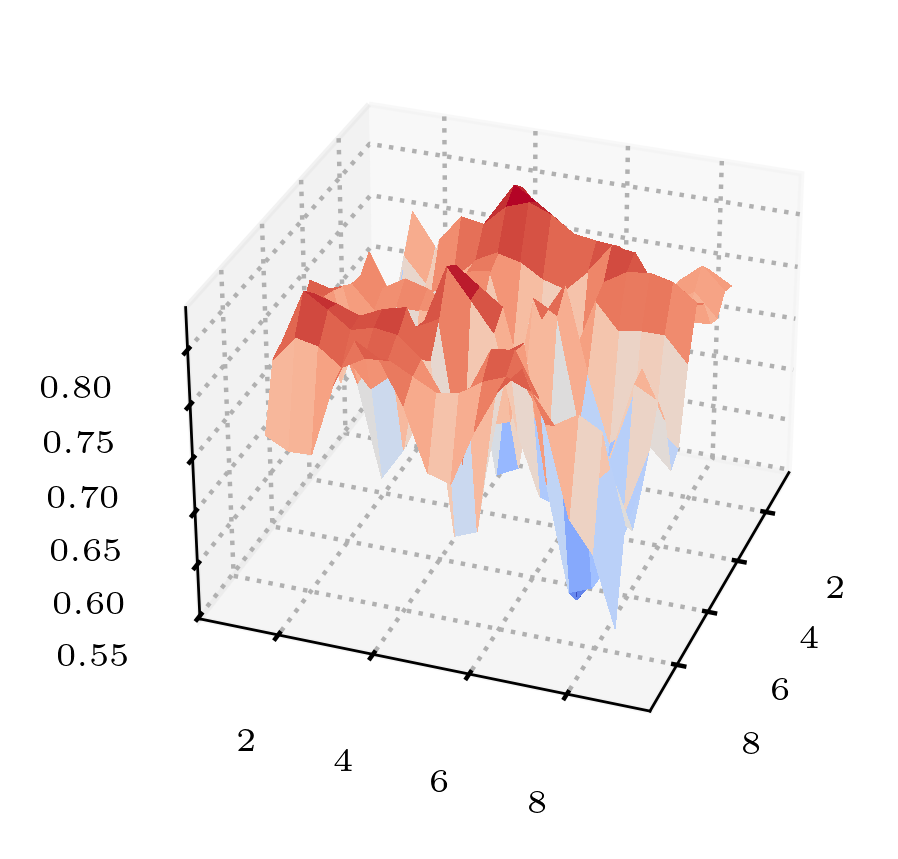

In [35]:
mesh3d(df["FF Layers (n)"], df["Enc Layers (n)"], df.AUROC)


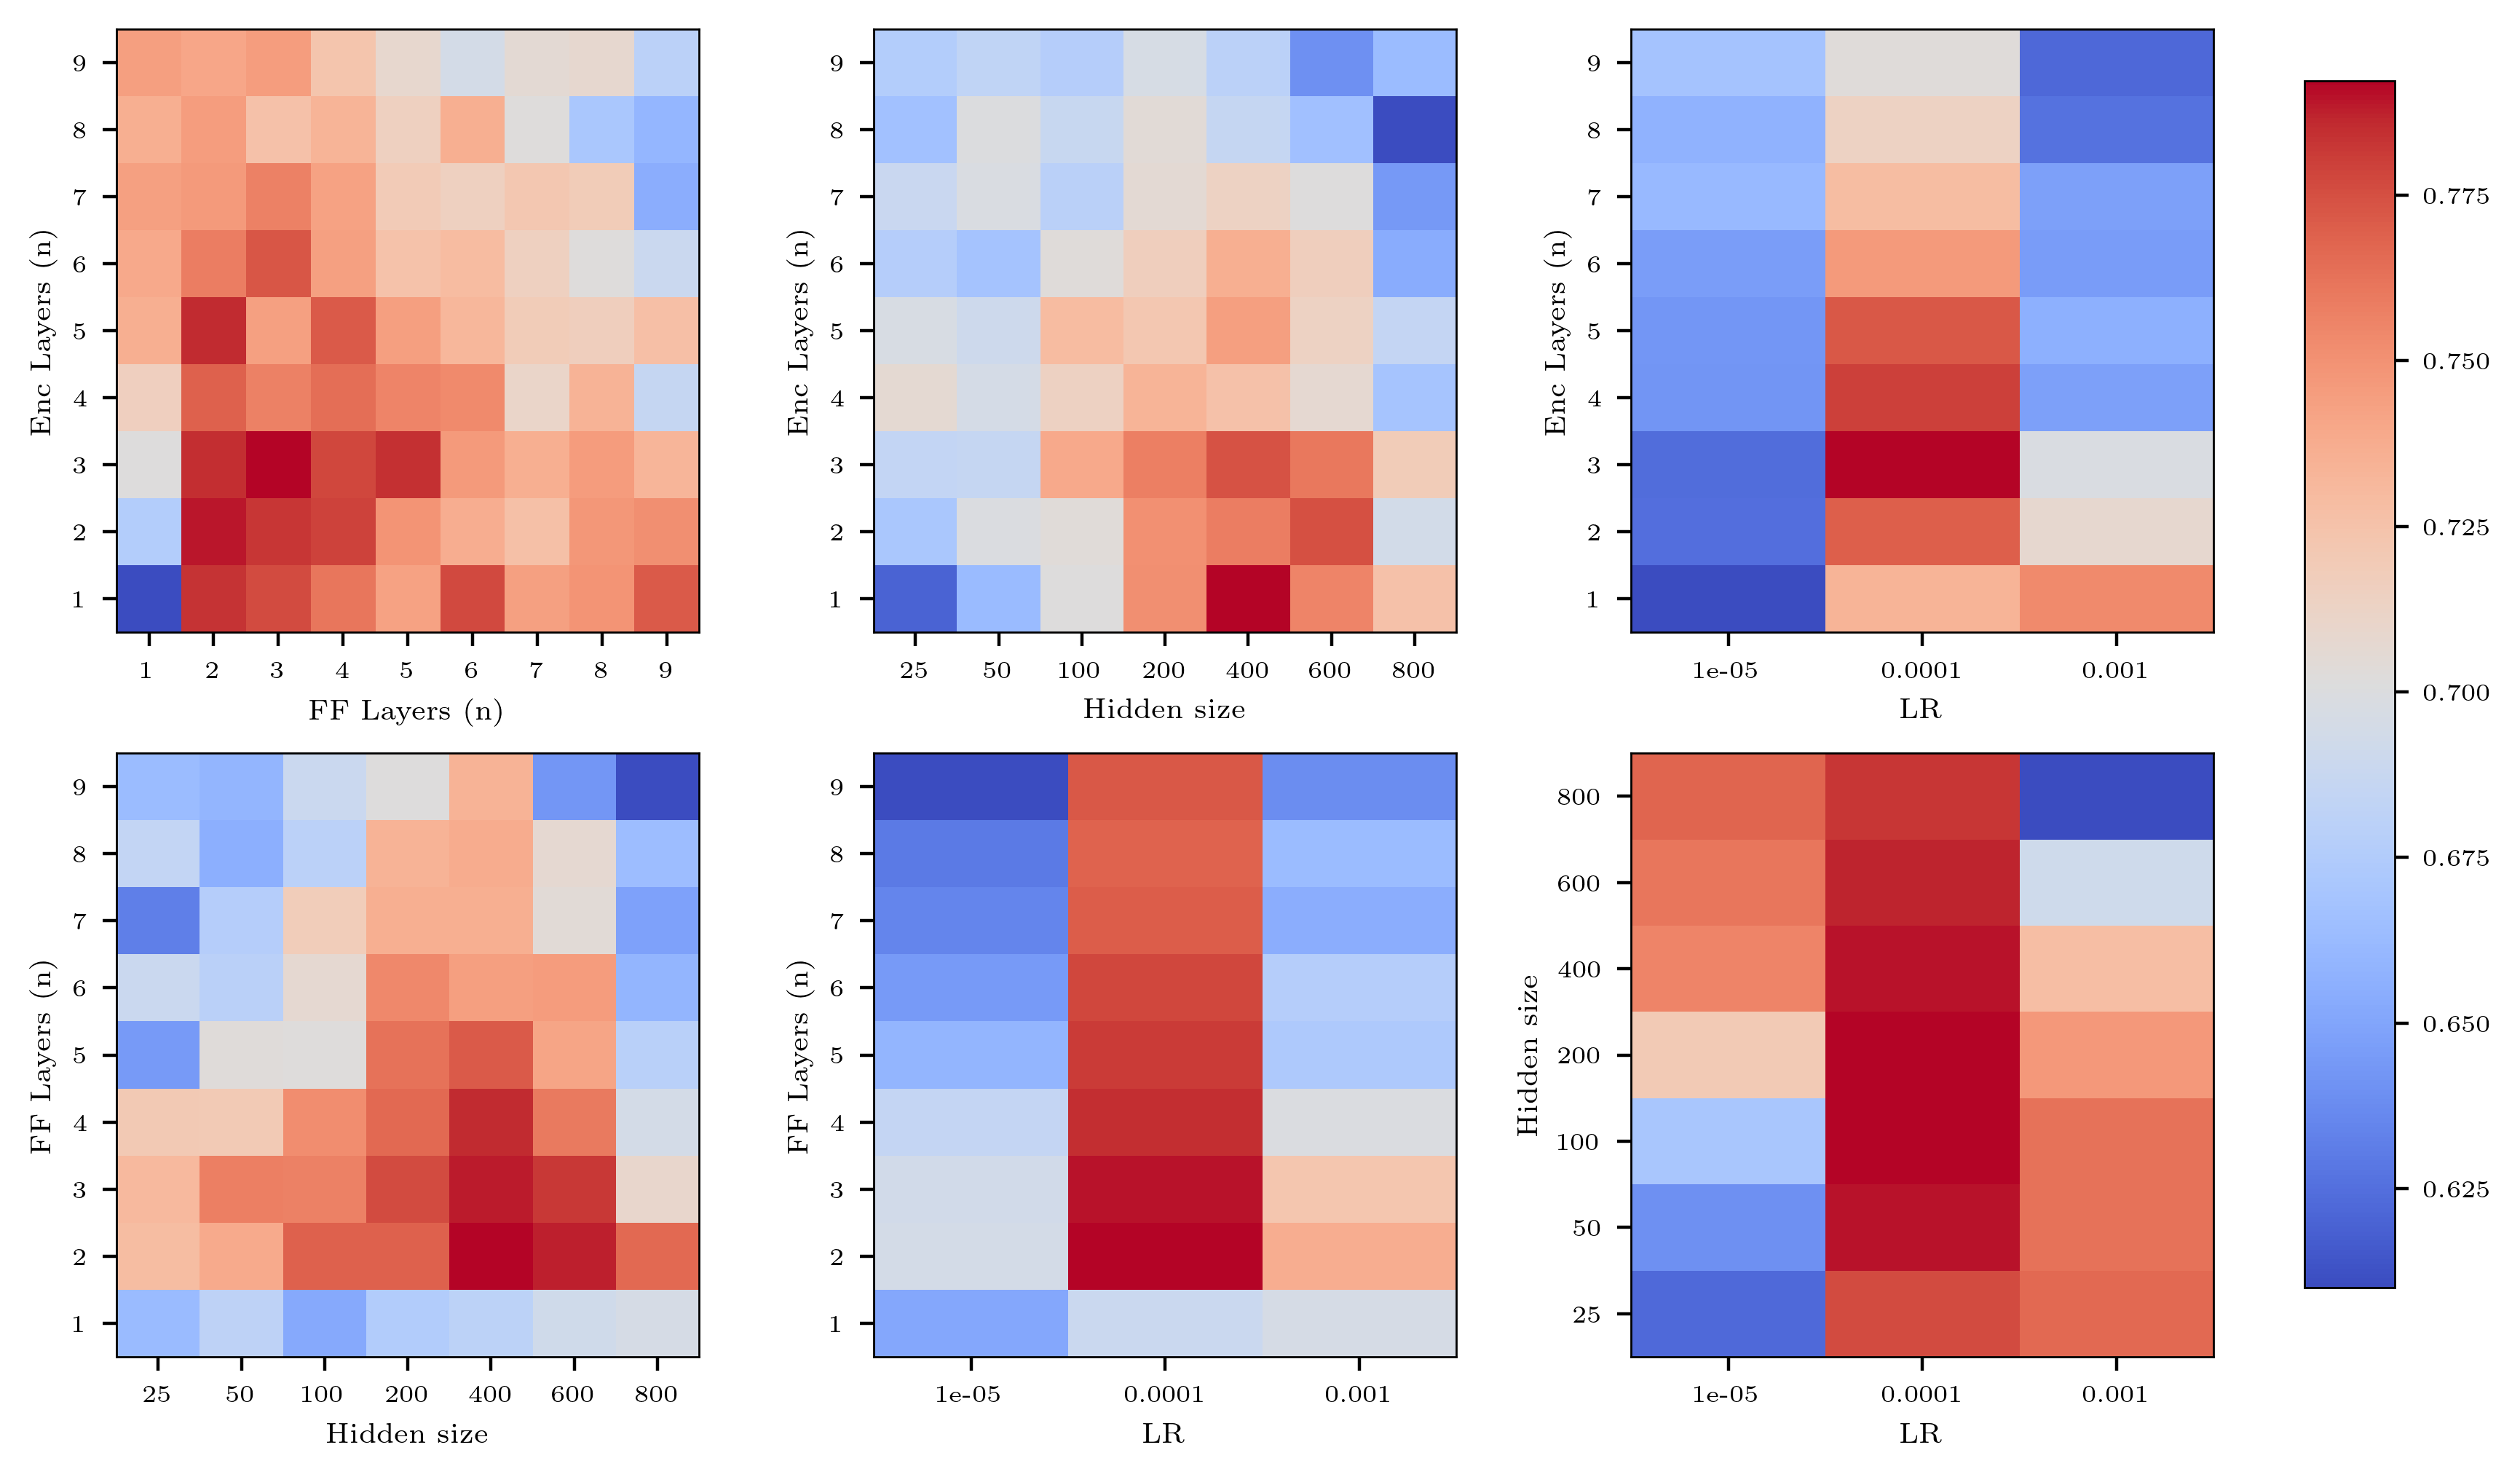

In [38]:
from itertools import combinations

def mesh2d(x,y,z, xlab, ylab, ax):
    # xlb = x.min()
    # xub = x.max()
    # ylb = y.min()
    # # yub = y.max()
    # # X = np.linspace(xlb - (xub - xlb) * 0.01, xub + (xub - xlb) * 0.01, 8 *2)
    # # Y = np.linspace(ylb - (yub - ylb) * 0.01, yub + (yub - ylb) * 0.01, 8 *2)
    X, Y = np.meshgrid(x, y)
    # Z = griddata((x, y), z, (X, Y), method='cubic')
    # Z = np.array(z).reshape(len(y), len(y))
    c = ax.pcolormesh(range(len(x)), range(len(y)), z, cmap=cm.coolwarm, shading="nearest", vmin=np.min(z), vmax=np.max(z))
    ax.set_xticks(ticks=range(len(x)), labels=x)
    ax.set_yticks(ticks=range(len(y)), labels=y)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    return c


DATA = df

combs = list(combinations(groups, 2))
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(2.96 * 3 + (2.96 *0.5),  2.96*2))

pick = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        col1, col2 = combs[pick]
        tmp_data =df.pivot_table(columns=col2, index=col1, values='AUROC')
        x = tmp_data.columns
        y = tmp_data.index
        z = tmp_data.to_numpy()
        c = mesh2d(x, y, z, col2, col1, ax[i, j])
        pick +=1

fig.subplots_adjust(right=0.82, wspace=0.3, hspace=0.2)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
# plot colorbar
cbar = fig.colorbar(c, cax=cbar_ax)
plt.savefig(optim_data.joinpath("params.pdf"))



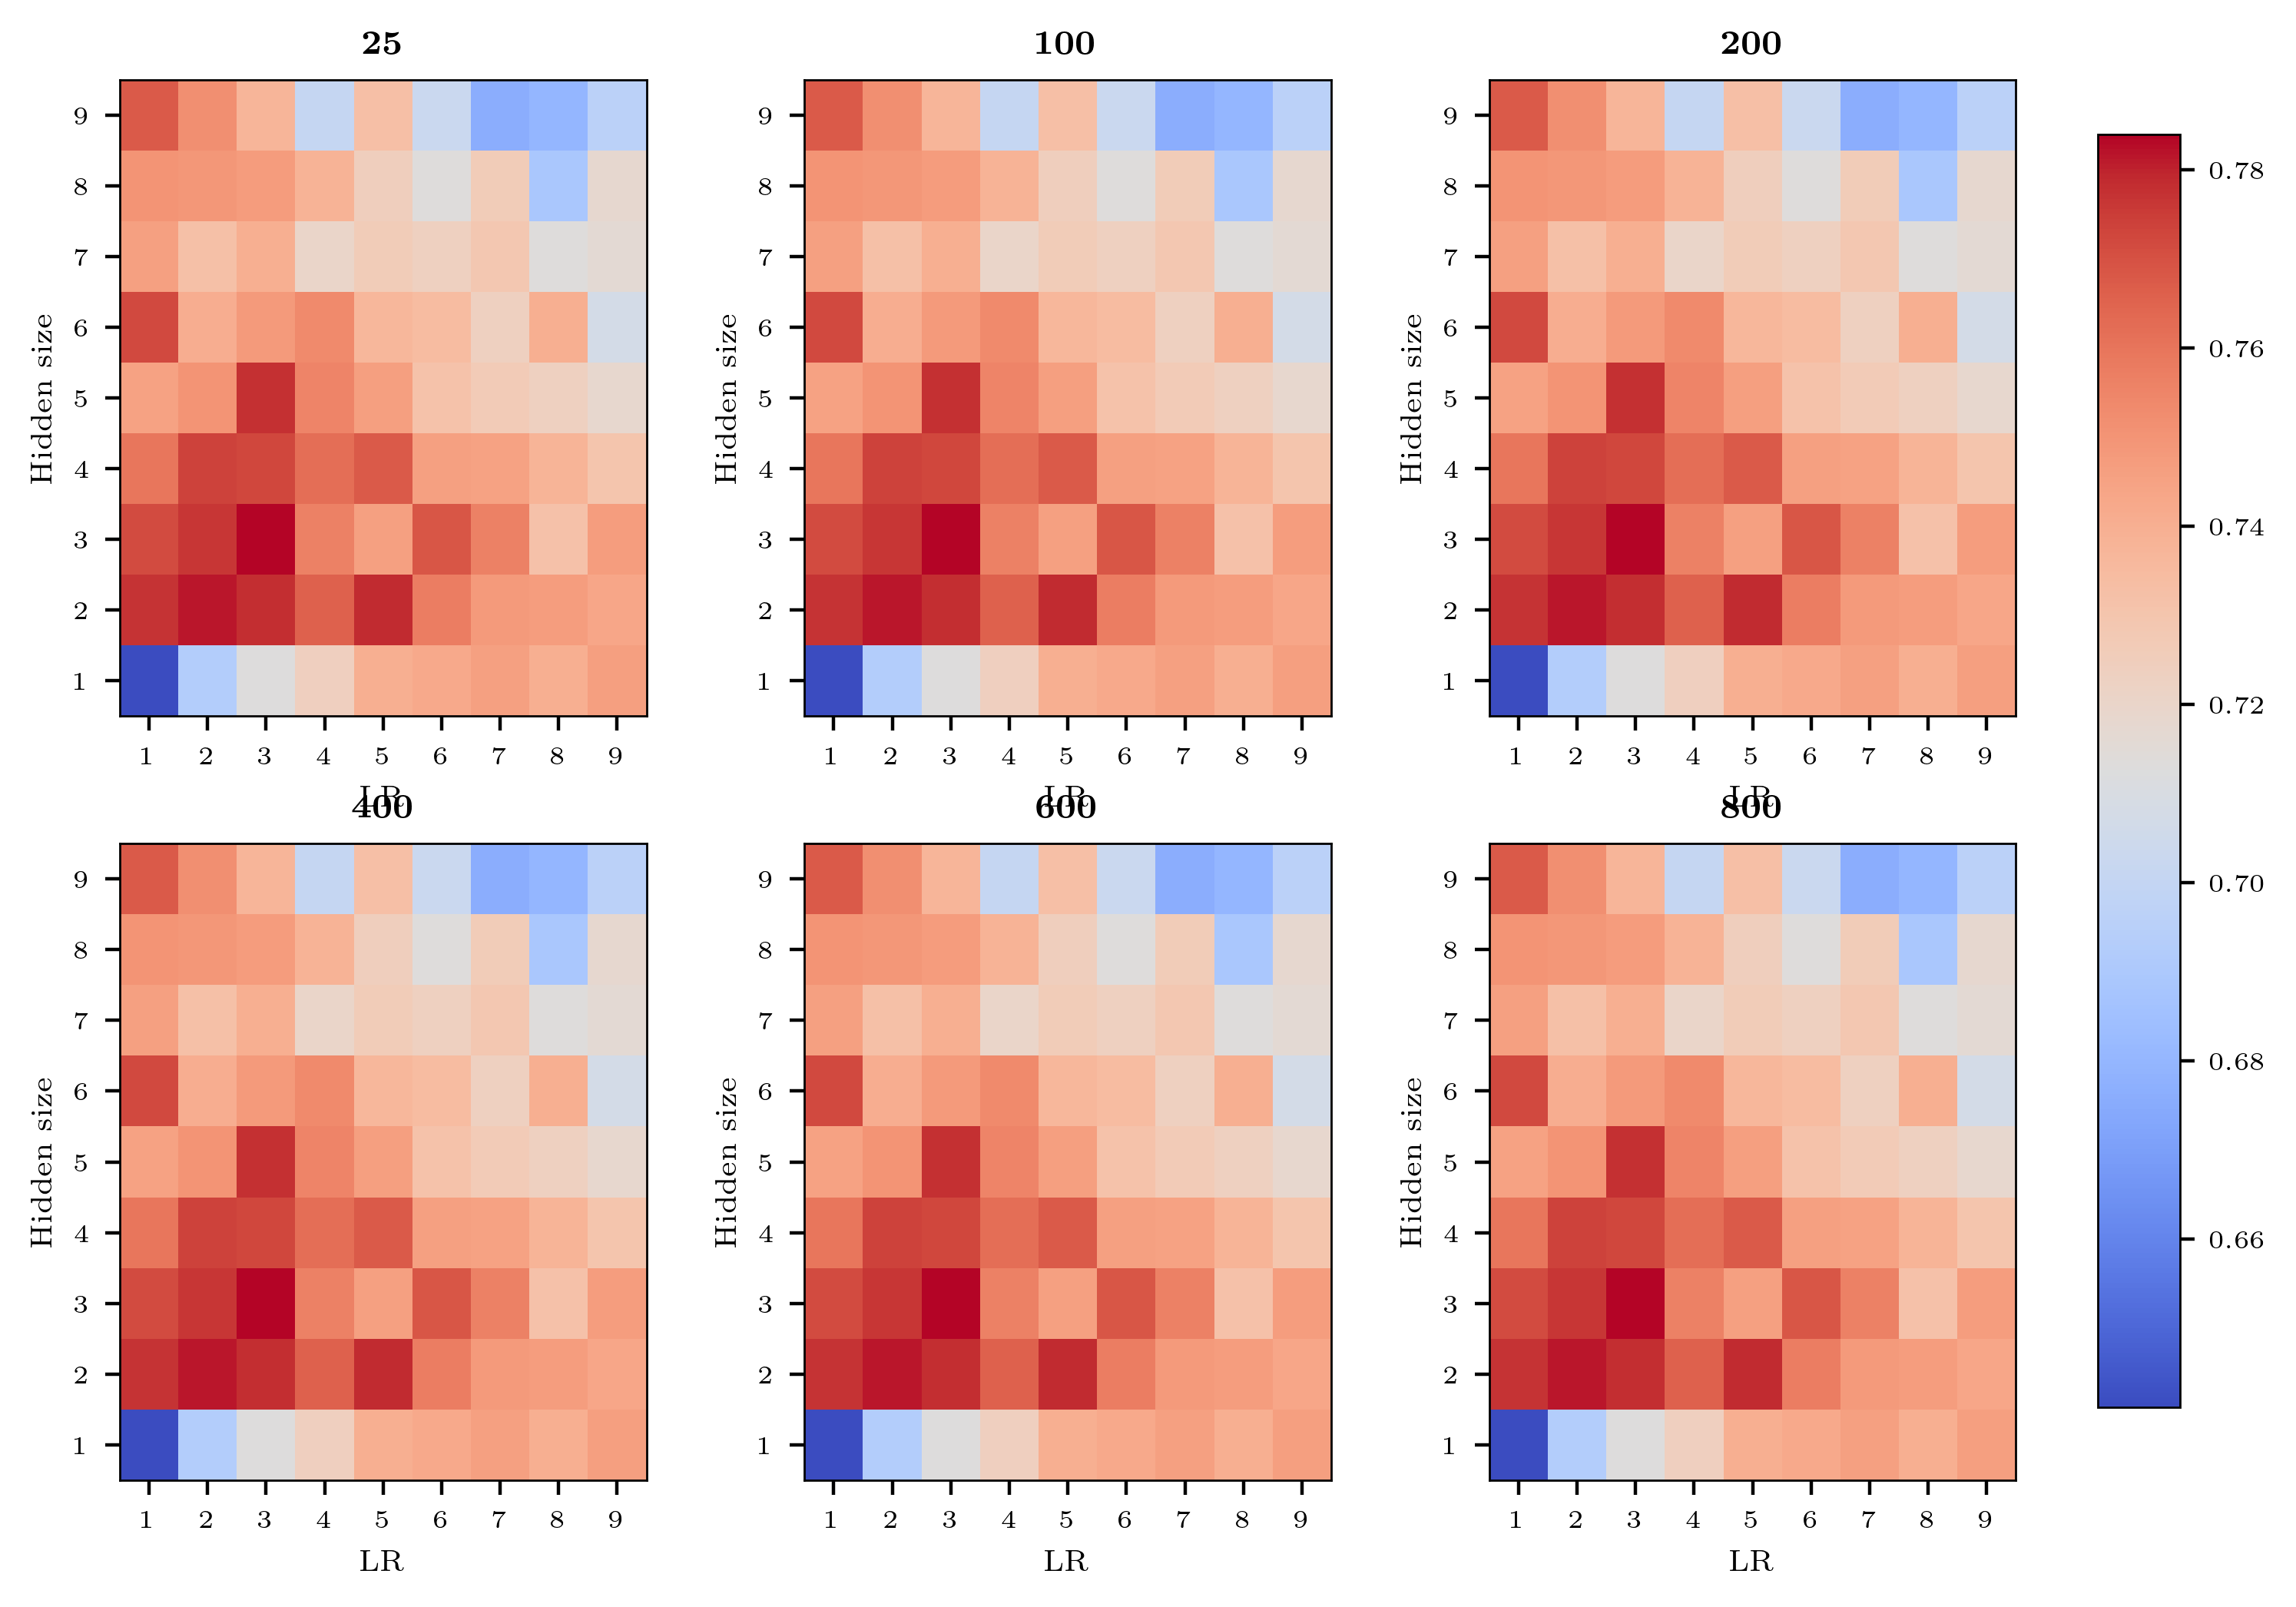

In [ ]:

DATA = df.copy()
DATA = DATA.loc[:, DATA.columns != "Loss"].loc[DATA["LR"] == 0.0001]
DATA = DATA[["Enc Layers (n)", "FF Layers (n)", "Hidden size", "AUROC"]]
DATA = DATA.loc[DATA["Hidden size"].isin([25, 100, 200, 400, 600, 800])]
fig, ax = plt.subplots(2, 3, figsize=(2.96*3, 2.96 *2))

groups = list(DATA.groupby("Hidden size"))

ii=0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        name, frame = groups[ii]
        name = r"\textbf{" + str(name) + r"}"
        tmp_data = df.pivot_table(columns="Enc Layers (n)", index="FF Layers (n)", values='AUROC')
        # print(tmp_data)
        x = tmp_data.columns
        y = tmp_data.index
        z = tmp_data.to_numpy()
        c = mesh2d(x, y, z, col2, col1, ax[i, j])
        ax[i,j].set_title(name)
        ii +=1
fig.subplots_adjust(right=0.82, wspace=0.3, hspace=0.2)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
# plot colorbar
cbar = fig.colorbar(c, cax=cbar_ax)
plt.savefig(optim_data.joinpath("params.pdf"))



In [240]:
DATA = df.copy()
DATA = DATA.loc[:, DATA.columns != "Loss"].loc[DATA["LR"] == 0.0001]
DATA = DATA[["Enc Layers (n)", "FF Layers (n)", "Hidden size", "AUROC"]]
# DATA = DATA.loc[DATA["Hidden size"].isin([25, 100, 200, 400, 600, 800])]
DATA["Total Layers"] = DATA["Enc Layers (n)"] + DATA["FF Layers (n)"]

In [278]:
top15 = DATA.sort_values(by="AUROC", ascending=False)[["Enc Layers (n)", "FF Layers (n)", "Hidden size", "Total Layers", "AUROC"]].head(15)
top15.index = range(1, top15.shape[0]+1)
print(top15.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
 & Enc Layers (n) & FF Layers (n) & Hidden size & Total Layers & AUROC \\
\midrule
1 & 3 & 4 & 400 & 7 & 0.850 \\
2 & 4 & 2 & 800 & 6 & 0.849 \\
3 & 3 & 4 & 800 & 7 & 0.849 \\
4 & 2 & 2 & 800 & 4 & 0.847 \\
5 & 2 & 3 & 800 & 5 & 0.846 \\
6 & 2 & 3 & 600 & 5 & 0.846 \\
7 & 3 & 7 & 400 & 10 & 0.844 \\
8 & 3 & 3 & 600 & 6 & 0.844 \\
9 & 5 & 4 & 400 & 9 & 0.844 \\
10 & 3 & 3 & 400 & 6 & 0.844 \\
11 & 3 & 7 & 600 & 10 & 0.843 \\
12 & 3 & 5 & 800 & 8 & 0.843 \\
13 & 2 & 2 & 400 & 4 & 0.843 \\
14 & 4 & 4 & 200 & 8 & 0.842 \\
15 & 2 & 7 & 600 & 9 & 0.842 \\
\bottomrule
\end{tabular}



In [323]:
print(DATA.loc[DATA["AUROC"] > 0.82].describe().to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
 & Enc Layers (n) & FF Layers (n) & Hidden size & AUROC & Total Layers \\
\midrule
count & 102.000 & 102.000 & 102.000 & 102.000 & 102.000 \\
mean & 3.196 & 5.020 & 380.147 & 0.831 & 8.216 \\
std & 1.211 & 2.291 & 256.460 & 0.008 & 2.642 \\
min & 1.000 & 2.000 & 25.000 & 0.820 & 3.000 \\
25% & 2.000 & 3.000 & 200.000 & 0.826 & 6.000 \\
50% & 3.000 & 5.000 & 400.000 & 0.830 & 8.000 \\
75% & 4.000 & 7.000 & 600.000 & 0.836 & 10.000 \\
max & 6.000 & 9.000 & 800.000 & 0.850 & 14.000 \\
\bottomrule
\end{tabular}



In [320]:
DATA.loc[DATA["AUROC"] > 0.818131].agg(["mean", "median"])

,Enc Layers (n),FF Layers (n),Hidden size,AUROC,Total Layers
mean,3.201754,5.026316,376.973684,0.82975,8.22807
median,3.000000,5.000000,400.000000,0.82799,8.50000


In [308]:
DATA.loc[DATA["AUROC"] > 0.818131].mean()

Enc Layers (n)      3.201754
FF Layers (n)       5.026316
Hidden size       376.973684
AUROC               0.829750
Total Layers        8.228070
dtype: float64

In [319]:
DATA.loc[DATA["AUROC"] > 0.818131].mode()

,Enc Layers (n),FF Layers (n),Hidden size,AUROC,Total Layers
0,3,4,200,0.832755,9


In [311]:
Q1 = DATA['AUROC'].quantile(0.25)
Q3 = DATA['AUROC'].quantile(0.75)
IQR = Q3 - Q1

In [312]:
IQR

0.060967445801850206

In [307]:
DATA.groupby(["Enc Layers (n)"]).count()

,FF Layers (n),Hidden size,AUROC,Total Layers
Enc Layers (n),,,,
1,50,50,50,50
2,50,50,50,50
3,56,56,56,56
4,51,51,51,51
5,54,54,54,54
6,52,52,52,52
7,43,43,43,43
8,49,49,49,49
9,48,48,48,48


In [290]:
DATA.describe()

,Enc Layers (n),FF Layers (n),Hidden size,AUROC,Total Layers
count,453.000000,453.000000,453.000000,453.000000,453.000000
mean,4.920530,5.033113,311.147903,0.786986,9.953642
std,2.556935,2.541036,277.452671,0.037532,3.612915
min,1.000000,1.000000,25.000000,0.631599,2.000000
25%,3.000000,3.000000,50.000000,0.757164,7.000000
50%,5.000000,5.000000,200.000000,0.791755,10.000000
75%,7.000000,7.000000,600.000000,0.818131,12.000000
max,9.000000,9.000000,800.000000,0.849996,18.000000


In [ ]:
plt.scatter(df['x'], df['y'], s=df['z']*1000, alpha=0.5)

,Enc Layers (n),FF Layers (n),Hidden size,LR,AUROC
1,1,1,25,0.0001,0.631599
5,1,1,100,0.0001,0.631616
8,1,1,200,0.0001,0.651858
12,1,1,600,0.0001,0.675565
15,1,1,800,0.0001,0.656572
...,...,...,...,...,...
1332,9,9,100,0.0001,0.765915
1335,9,9,200,0.0001,0.747730
1338,9,9,400,0.0001,0.760198
1339,9,9,600,0.0001,0.737730


In [ ]:
#mesh2d(tmp_df["Enc Layers (n)"].values, tmp_df["FF Layers (n)"].values, tmp_df["AUROC"], "Enc Layers (n)", "FF Layers (n)", ax)

In [81]:
combs = list(combinations(groups, 3))

In [82]:
combs

[('Enc Layers (n)', 'FF Layers (n)', 'Hidden size'),
 ('Enc Layers (n)', 'FF Layers (n)', 'LR'),
 ('Enc Layers (n)', 'Hidden size', 'LR'),
 ('FF Layers (n)', 'Hidden size', 'LR')]

In [ ]:
for col1, col2 in combs:
    tmp_df = DATA.groupby().mean()
    print(tmp_df)
    # for x, y in DATA[col1].unique()
    # tmp_df = DATA.loc[(DATA[col1] == x) & (DATA[col2] == y)]

                              Hidden size        LR      Loss     AUROC
Enc Layers (n) FF Layers (n)                                           
1              1               330.882353  0.000328  0.710122  0.641114
               2               290.789474  0.000351  0.574416  0.776816
               3               272.222222  0.000365  0.596005  0.771634
               4               251.388889  0.000315  0.606615  0.759869
               5               295.000000  0.000370  0.909389  0.745417
...                                   ...       ...       ...       ...
9              5               296.052632  0.000351  0.604039  0.718151
               6               332.894737  0.000403  0.720832  0.707288
               7               311.764706  0.000391  0.736728  0.716033
               8               259.615385  0.000342  0.612901  0.717748
               9               304.166667  0.000370  1.216992  0.696367

[81 rows x 4 columns]
                            FF Layers (n)

In [74]:
tmp_df

,Enc Layers (n),FF Layers (n),Hidden size,LR,Loss,AUROC


In [47]:
df.sort_values(ascending=False, by="AUROC").head(25)

,Enc Layers (n),FF Layers (n),Hidden size,LR,Loss,AUROC
30,1,2,400,0.0010,0.534395,0.857725
368,3,4,400,0.0001,0.550535,0.849996
490,4,2,800,0.0001,0.546309,0.849262
372,3,4,800,0.0001,0.597743,0.848660
183,2,2,800,0.0001,0.492873,0.847084
199,2,3,800,0.0001,0.540449,0.846065
196,2,3,600,0.0001,0.533699,0.845771
417,3,7,400,0.0001,0.625382,0.844401
353,3,3,600,0.0001,0.540753,0.844302
671,5,4,400,0.0001,0.540742,0.844031


# Parameter search 2


In [48]:
param2 = Path("../media2/binary/optimization6")
opt = pd.read_table(param2.joinpath("test_stats.tsv"), index_col=0)
opt = opt.drop(columns=["Aggregation", "TF", "Target", "Dataset"])

In [49]:
opt.columns

Index(['Enc Layers (n)', 'FF Layers (n)', 'Hidden size', 'LR', 'Run', 'Label',
       'Pred'],
      dtype='object')

In [50]:
groups = opt.columns.tolist()
groups.pop(-1)
groups.pop(-1)
groups.pop(-1)

names = []
losses = []
roc = []

for name, frame in opt.groupby(groups):
    lab, pred = frame.Label, frame.Pred
    names.append(name)
    losses.append(bceloss(lab, pred))
    roc.append(auroc(lab, pred))
    

 
df2 = pd.concat((pd.DataFrame(names, columns = groups), pd.DataFrame(losses, columns=["Loss"]), pd.DataFrame(roc, columns=["AUROC"])), axis=1)

In [51]:
df2.sort_values(ascending=False, by="AUROC")

,Enc Layers (n),FF Layers (n),Hidden size,LR,Loss,AUROC
16,1,2,600,0.0005,0.639997,0.748500
13,1,2,400,0.0005,0.635065,0.742213
25,1,3,600,0.0005,0.651078,0.740966
31,1,4,400,0.0005,0.668213,0.734363
34,1,4,600,0.0005,0.692344,0.732942
...,...,...,...,...,...,...
89,2,4,600,0.0050,5.578644,0.510241
269,5,6,600,0.0050,6.324072,0.509691
137,3,4,200,0.0050,6.105254,0.509561
161,3,6,600,0.0050,5.206672,0.509469


In [ ]:
from itertools import combinations

def mesh2d(x,y,z, xlab, ylab, ax):
    # xlb = x.min()
    # xub = x.max()
    # ylb = y.min()
    # # yub = y.max()
    # # X = np.linspace(xlb - (xub - xlb) * 0.01, xub + (xub - xlb) * 0.01, 8 *2)
    # # Y = np.linspace(ylb - (yub - ylb) * 0.01, yub + (yub - ylb) * 0.01, 8 *2)
    X, Y = np.meshgrid(x, y)
    # Z = griddata((x, y), z, (X, Y), method='cubic')
    # Z = np.array(z).reshape(len(y), len(y))
    c = ax.pcolormesh(range(len(x)), range(len(y)), z, cmap=cm.coolwarm, shading="nearest", vmin=np.min(z), vmax=np.max(z))
    ax.set_xticks(ticks=range(len(x)), labels=x)
    ax.set_yticks(ticks=range(len(y)), labels=y)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    return c


DATA = df

combs = list(combinations(groups, 2))
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(2.96 * 3 + (2.96 *0.5),  2.96*2))

pick = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        col1, col2 = combs[pick]
        tmp_data =df.pivot_table(columns=col2, index=col1, values='AUROC')
        x = tmp_data.columns
        y = tmp_data.index
        z = tmp_data.to_numpy()
        c = mesh2d(x, y, z, col2, col1, ax[i, j])
        pick +=1

fig.subplots_adjust(right=0.82, wspace=0.3, hspace=0.2)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
# plot colorbar
cbar = fig.colorbar(c, cax=cbar_ax) 

